In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100 #생성자의 입력으로 사용될 noise vector 크기

### 생성자 구현

- 하나의 은닉층을 가짐
- z벡터 입력을 받아 28 x 28 x 1의 이미지 생성
- 활성화함수로 은닉층에는 LeakyReLU, 출력층에는 tanh 사용

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim = z_dim)) #Fully Connected layer
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(28 * 28 * 1, activation = 'tanh')) #output layer
    model.add(Reshape(img_shape))
    return model

### 판별자 구현

- 28 x 28 x 1의 이미지를 받아 얼마나 진짜인지를 나타내는 확률 출력
- 은닉층은 LeakyReLU 활성화 함수와 128개의 hidden unit을 가짐
- 출력층에 sigmoid 함수

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

### 모델 생성

- 생성자를 훈련하기 위해 연결된 모델에서는 판별자의 파라미터를 동결하기 위해 discriminator.trainable을 false로 지정
- 판별자는 독립적으로 컴파일된 모델로 훈련
- 손실 함수로 이진 교차 엔트로피(binary crossentropy)사용
- 최적화 방법으로  Adam(Adaptive moment estimation) 알고리즘 사용

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator) #생성자를 훈련하기 위해 동결한 판별자로 GAN 컴파일
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())

### 훈련

1. 랜덤한 MNIST 이미지의 미니배치를 진짜 샘플로, 랜덤한 잡음벡터 z로부터 가짜 이미지의 미니배치 생성
2. 이를 사용해 생성자의 파라미터를 고장한 채로 판별자의 네트워크 훈련
3. 가짜 이미지의 미니배치를 생성하고 이를 사용해 판별자의 파라미터를 고정한 채로 생성자 네트워크 훈련

- OneHotEncoding 사용(진짜 이미지 = 1, 가짜 이미지 = 0)
- 준정규분포(평균이 0 표준편차가 1인 종 모양의 곡선)에서 샘플링하여 z 벡터 생성
- 훈련 데이터셋의 이미지를 -1 ~ 1의 범위로 스케일 조정(tanh를 출력층에 사용하기 때문)

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, _), (_, _) = mnist.load_data()
    
    X_train = X_train / 255. -1.0
    X_train = np.expand_dims(X_train, axis = 3)
    
    real = np.ones((batch_size, 1)) #진짜 이미지 레이블 1
    fake = np.zeros((batch_size, 1)) #가짜 이미지 레이블 0
    
    for iteration in range(iterations):
        idx = np.random.randint(0, X_train.shape[0], batch_size) #진짜 이미지에서 랜덤 배치
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100)) #가짜 이미지 배치 생성
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real) #판별자 훈련
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100)) #가짜 이미지 배치 생성
        gen_imgs = generator.predict(z) 
        
        g_loss = gan.train_on_batch(z, real) #생성자 훈련
        
        if (iteration + 1) %  sample_interval == 0:
            losses.append((d_loss, g_loss)) #훈련 종료 후 그래프 그리기 위한 값 저장
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D 손실: %f, 정확도: : %.2f%%] [G 손실: %f]" %(iteration +1, d_loss, 100.0 * accuracy, g_loss))
            
            sample_images(generator) #생성된 이미지 샘플 출력

### 샘플 이미지 출력

생성자가 합성한 4x4 이미지 그리드 출력

In [8]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim)) #random noise vector
    
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5 #이미지 픽셀 값을 0~1 범위로 조정
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize = (4, 4), sharey = True, sharex = True) #이미지 그리드 설정
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray') #이미지 그리드 출력
            axs[i, j].axis('off')
            cnt += 1

### 모델 실행

하이퍼파라미터인 반복 횟수, 배치 크기를 설정하고 모델 훈련

1000 [D 손실: 0.001606, 정확도: : 100.00%] [G 손실: 6.342481]
2000 [D 손실: 0.179745, 정확도: : 94.92%] [G 손실: 3.219276]
3000 [D 손실: 0.552359, 정확도: : 71.48%] [G 손실: 1.500959]
4000 [D 손실: 0.713110, 정확도: : 57.42%] [G 손실: 1.412125]
5000 [D 손실: 1.232219, 정확도: : 20.70%] [G 손실: 0.708315]
6000 [D 손실: 0.549497, 정확도: : 75.78%] [G 손실: 1.308082]
7000 [D 손실: 0.969768, 정확도: : 46.48%] [G 손실: 0.929050]
8000 [D 손실: 0.354591, 정확도: : 89.45%] [G 손실: 1.749097]
9000 [D 손실: 0.862969, 정확도: : 44.92%] [G 손실: 1.319602]
10000 [D 손실: 0.821064, 정확도: : 48.05%] [G 손실: 1.143893]
11000 [D 손실: 0.712454, 정확도: : 61.33%] [G 손실: 1.413759]
12000 [D 손실: 0.712339, 정확도: : 58.20%] [G 손실: 1.126344]
13000 [D 손실: 0.349294, 정확도: : 86.33%] [G 손실: 2.218302]
14000 [D 손실: 0.641172, 정확도: : 70.70%] [G 손실: 1.721623]
15000 [D 손실: 0.346770, 정확도: : 87.50%] [G 손실: 1.707744]
16000 [D 손실: 0.732266, 정확도: : 61.33%] [G 손실: 1.296212]
17000 [D 손실: 0.674300, 정확도: : 62.11%] [G 손실: 1.456277]
18000 [D 손실: 1.094562, 정확도: : 36.33%] [G 손실: 0.932792]
19000 [D 손실: 0.866

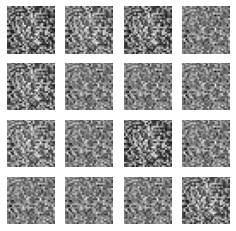

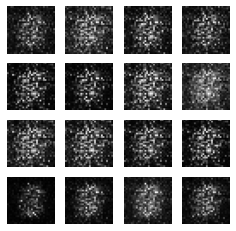

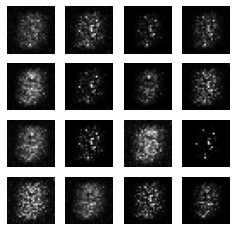

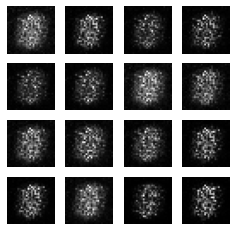

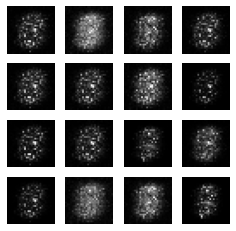

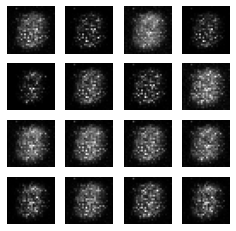

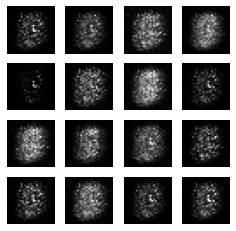

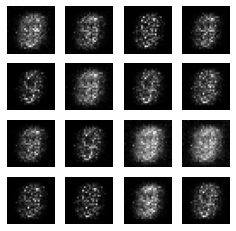

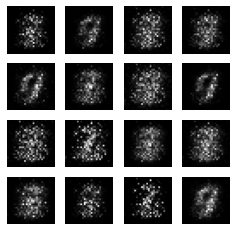

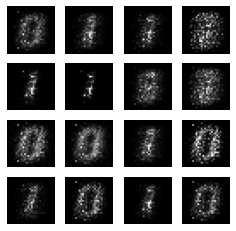

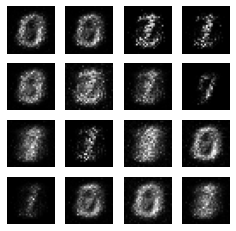

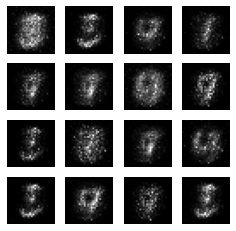

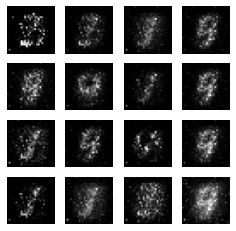

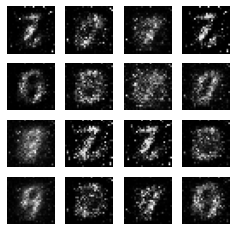

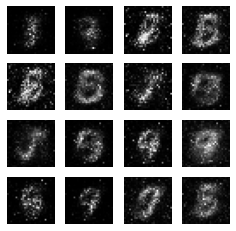

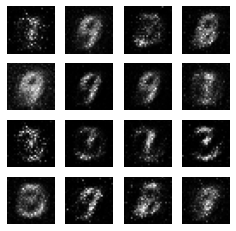

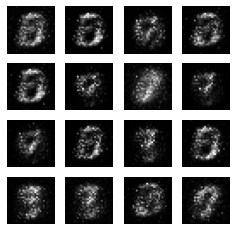

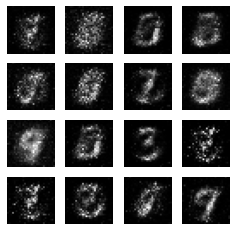

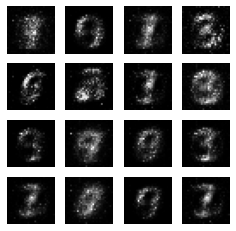

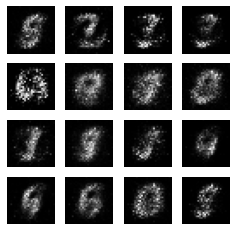

In [9]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)